In [50]:
from astropy.io import fits
hdu = fits.open('/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.fits')[0]
print(hdu.header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3617                                                  NAXIS2  =                 3617                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CTYPE1  = 'RA---SIN'           / Axis type                                      CDELT1  =        -3.317767E-04 / Axis coordinate increment                      CRPIX1  =         1.809000E+03 / Axis coordinate reference pixel                CROTA1  =         0.000000E+00 / Axis coordinate rotation                       CRVAL1  =    22.98950361110778 / Axis coordinate value at CRPIX                 CTYPE2  = 'DEC--SIN'           / Axis ty

In [78]:
# save as crtf_to_yolo.py
#!/usr/bin/env python3
import re
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import os
from astropy.coordinates import SkyCoord
import astropy.units as u

In [88]:
# Define directories
image_dir = '/users/vutomi/Source_Detection/YOLOs/Data/images'
crtf_dir = '/users/vutomi/Source_Detection/YOLOs/Data/labels'
output_dir = '/users/vutomi/Source_Detection/YOLOs/Data/labels'
os.makedirs(output_dir, exist_ok=True)

# Focus on Abell 209 dataset
datasets = [
    {'fits': '/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.fits', 'crtf': '/users/vutomi/Source_Detection/abell_209_region_label_ds9.txt'}  # Adjust FITS name if different
]

In [89]:
def parse_crtf(crtf_file):
    """
    Parse DS9 file with box regions in decimal degrees and arcseconds (using " suffix).
    Returns (ra_deg, dec_deg, width_deg, height_deg) with detailed debugging.
    """
    regions = []
    try:
        with open(crtf_file, 'r') as f:
            for line_num, line in enumerate(f, 1):
                if 'box' in line:
                    match = re.search(r'box\s*\(\s*(\d+\.\d+)\s*,\s*(\-?\d+\.\d+)\s*,\s*(\d+\.\d+)"\s*,\s*(\d+\.\d+)"(?:\s*,\s*\d+\.?\d*)?\s*(?:#.*)?', line, re.IGNORECASE)
                    if not match:
                        print(f"Warning: Invalid box region in line {line_num}: {line.strip()}")
                        continue
                    ra_deg, dec_deg, width_arcsec, height_arcsec = match.groups()
                    ra_deg = float(ra_deg)
                    dec_deg = float(dec_deg)
                    width_arcsec = float(width_arcsec.replace('"', ''))
                    height_arcsec = float(height_arcsec.replace('"', ''))
                    print(f"Line {line_num}: Raw match - RA={ra_deg}, Dec={dec_deg}, Width={width_arcsec}\", Height={height_arcsec}\"")

                    # Convert width and height from arcseconds to degrees
                    try:
                        width_deg = width_arcsec / 3600.0
                        height_deg = height_arcsec / 3600.0
                    except ValueError as e:
                        print(f"Error converting width/height in line {line_num}: {e}")
                        continue

                    regions.append((ra_deg, dec_deg, width_deg, height_deg))
                    print(f"Line {line_num}: Converted - RA={ra_deg}, Dec={dec_deg}, Width={width_deg}, Height={height_deg}")
    except FileNotFoundError:
        print(f"CRTF file not found: {crtf_file}")
        return []
    except Exception as e:
        print(f"Unexpected error parsing CRTF file {crtf_file}: {e}")
        return []
    return regions

In [90]:
def crtf_to_yolo(fits_file, crtf_file, output_label):
    """
    Convert CRTF world coordinates to YOLOv5 normalized pixel coordinates for Abell 209.
    Uses FITS header-derived image size (3617x3617).
    """
    try:
        # Open FITS file and extract header
        fits_path = os.path.join(image_dir, fits_file)
        hdu = fits.open(fits_path)[0]
        header = hdu.header

        # Construct WCS and subset to 2D with explicit celestial axes
        wcs = WCS(header)
        print(f"Original WCS axes: {wcs.wcs.naxis}")  # Debug: Check original axes
        wcs = WCS(naxis=2)
        wcs.wcs.ctype = ['RA---SIN', 'DEC--SIN']
        wcs.wcs.crval = [header['CRVAL1'], header['CRVAL2']]
        wcs.wcs.crpix = [header['CRPIX1'], header['CRPIX2']]
        wcs.wcs.cdelt = [header['CDELT1'], header['CDELT2']]
        print(f"Adjusted WCS axes: {wcs.wcs.naxis}")  # Debug: Check adjusted axes

        # Get image shape from FITS header
        img_shape = (header['NAXIS2'], header['NAXIS1'])  # (rows, columns) = (3617, 3617)
        print(f"Image shape: {img_shape}")

        # Parse CRTF file for regions
        crtf_path = os.path.join(crtf_dir, crtf_file)
        regions = parse_crtf(crtf_path)
        if not regions:
            print(f"No valid regions found in {crtf_path}, skipping.")
            return

        # Convert to YOLO format
        with open(output_label, 'w') as f:
            for ra, dec, width_deg, height_deg in regions:
                # Convert world coordinates to pixel coordinates
                world_coords = np.array([[ra, dec]])  # Shape (1, 2) for 2D
                pixel_coords = wcs.wcs_world2pix(world_coords, 0)[0]  # Extract first result
                x_center, y_center = pixel_coords[0], pixel_coords[1]

                # Calculate pixel scale and normalize dimensions
                pix_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # Convert deg to arcsec
                width = (width_deg * 3600 / pix_scale) / img_shape[1]  # Normalize width
                height = (height_deg * 3600 / pix_scale) / img_shape[0]  # Normalize height

                # Normalize center coordinates
                x_center_norm = x_center / img_shape[1]
                y_center_norm = 1 - (y_center / img_shape[0])  # Flip y-axis for YOLO convention

                # Ensure coordinates are within [0, 1]
                if 0 <= x_center_norm <= 1 and 0 <= y_center_norm <= 1 and width > 0 and height > 0:
                    f.write(f"0 {x_center_norm:.6f} {y_center_norm:.6f} {width:.6f} {height:.6f}\n")
                else:
                    print(f"Warning: Invalid coordinates for RA={ra}, Dec={dec} in {fits_path}, skipping.")

        print(f"YOLO labels saved at {output_label}")
    except Exception as e:
        print(f"Error processing {fits_path}: {e}")

In [91]:
# Process Abell 209
for dataset in datasets:
    fits_file = dataset['fits']
    crtf_file = dataset['crtf']
    output_label = os.path.join(output_dir, f"{os.path.splitext(fits_file)[0]}.txt")
    crtf_to_yolo(fits_file, crtf_file, output_label)

Original WCS axes: 4
Adjusted WCS axes: 2
Image shape: (3617, 3617)
Line 4: Raw match - RA=23.113916591, Dec=-13.30512913, Width=32.973", Height=54.9551"
Line 4: Converted - RA=23.113916591, Dec=-13.30512913, Width=0.009159166666666666, Height=0.015265305555555556
Line 5: Raw match - RA=23.256681016, Dec=-13.321046417, Width=71.4416", Height=60.4506"
Line 5: Converted - RA=23.256681016, Dec=-13.321046417, Width=0.019844888888888888, Height=0.016791833333333332
Line 6: Raw match - RA=23.239490267, Dec=-13.384415782, Width=49.4595", Height=54.9551"
Line 6: Converted - RA=23.239490267, Dec=-13.384415782, Width=0.01373875, Height=0.015265305555555556
Line 7: Raw match - RA=23.347731338, Dec=-13.362912938, Width=38.4685", Height=54.9551"
Line 7: Converted - RA=23.347731338, Dec=-13.362912938, Width=0.010685694444444444, Height=0.015265305555555556
Line 8: Raw match - RA=23.040962185, Dec=-13.331298752, Width=45.1701", Height=36.6437"
Line 8: Converted - RA=23.040962185, Dec=-13.331298752, W

In [92]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

# Load FITS and WCS
fits_path = '/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.fits'
hdu = fits.open(fits_path)[0]
wcs = WCS(naxis=2)
wcs.wcs.ctype = ['RA---SIN', 'DEC--SIN']
wcs.wcs.crval = [hdu.header['CRVAL1'], hdu.header['CRVAL2']]
wcs.wcs.crpix = [hdu.header['CRPIX1'], hdu.header['CRPIX2']]
wcs.wcs.cdelt = [hdu.header['CDELT1'], hdu.header['CDELT2']]
img_shape = (hdu.header['NAXIS2'], hdu.header['NAXIS1'])

# Read a sample line from the YOLO file
with open('/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.txt', 'r') as f:
    lines = f.readlines()[:5]  # First 5 lines
    for line in lines:
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line.strip().split())
        x_center = x_center_norm * img_shape[1]
        y_center = (1 - y_center_norm) * img_shape[0]  # Reverse the YOLO flip
        print(f"YOLO coords: x={x_center:.1f}, y={y_center:.1f}, w={width_norm:.6f}, h={height_norm:.6f}")
        # Convert back to world coordinates
        world_coords = wcs.wcs_pix2world([[x_center, y_center]], 0)[0]
        print(f"Back-converted RA={world_coords[0]:.6f}, Dec={world_coords[1]:.6f}")

YOLO coords: x=1443.1, y=2625.2, w=0.007632, h=0.012721
Back-converted RA=23.113917, Dec=-13.305130
YOLO coords: x=1024.4, y=2576.9, w=0.016537, h=0.013993
Back-converted RA=23.256681, Dec=-13.321046
YOLO coords: x=1075.0, y=2386.0, w=0.011449, h=0.012721
Back-converted RA=23.239490, Dec=-13.384415
YOLO coords: x=757.5, y=2450.4, w=0.008904, h=0.012721
Back-converted RA=23.347731, Dec=-13.362913
YOLO coords: x=1657.1, y=2546.4, w=0.010456, h=0.008482
Back-converted RA=23.040963, Dec=-13.331298


In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

fits_path = '/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.fits'
hdu = fits.open(fits_path)[0]
data = hdu.data
# Normalize data if needed (e.g., for radio intensity)
data = np.log1p(data - np.min(data))  # Adjust based on your data range
plt.imsave('/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209.png', data, cmap='gray', origin='lower')
print("Image saved as Abell_209.png")

Image saved as Abell_209.png


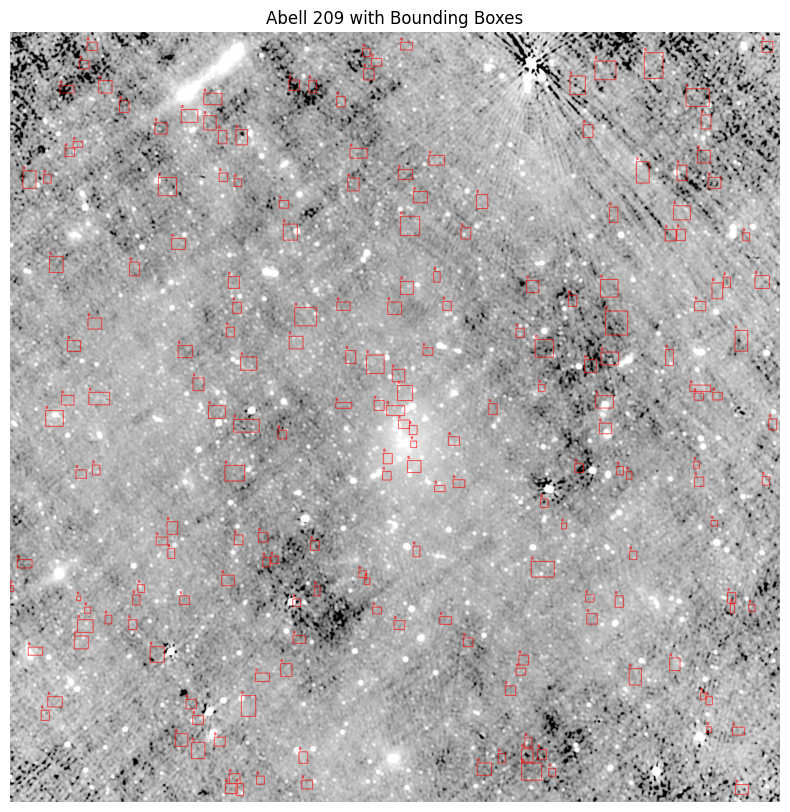

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

with open('/users/vutomi/Source_Detection/YOLOs/Data/images/Abell_209_aFix_pol_I_15arcsec_fcube_cor_2d.txt', 'r') as f:
    for line in f.readlines():  # First 5 boxes
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line.strip().split())
        x_center = int(x_center_norm * w)
        y_center = int((1 - y_center_norm) * h)  # Reverse YOLO flip
        width = int(width_norm * w)
        height = int(height_norm * h)
        x_min = int(x_center - width / 2)
        x_max = int(x_center + width / 2)
        y_min = int(y_center - height / 2)
        y_max = int(y_center + height / 2)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, f'{int(class_id)}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Abell 209 with Bounding Boxes')
plt.show()